# Imports

In [1]:
%matplotlib inline
# %matplotlib notebook
import numpy as np
import pandas as pd
import zipfile as z
import requests
import io
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium
import bokeh

from bokeh.io import hplot, vform
from bokeh.models import CustomJS, ColumnDataSource, Slider
from bokeh.plotting import Figure, show
from bokeh.io import save

# from bokeh.plotting import Figure
from bokeh.models import Range1d
from bokeh.tile_providers import STAMEN_TONER
# import bokeh.plotting as bk
from bokeh.io import output_notebook
output_notebook()

import seaborn as sns
sns.set()
mpl.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (20, 20)

Loading BokehJS ...

# Define function that converts longitude/latitude to Mercator

In [4]:
def convertLatLon_XY(lat, lon):
    mapWidth    = 2*20037508.34
    mapHeight   = 2*20037508.34

    x = (lon+180)*(mapWidth/360)

    latRad = lat*np.pi/180
    mercN = np.log(np.tan((np.pi/4)+(latRad/2)))
    y     = (mapHeight/2)-(mapWidth*mercN/(2*np.pi))
    
    return (x-mapWidth/2, y-mapHeight/2)

def convertLatLon_XY_fromDf(df):
    mapWidth    = 2*20037508.34
    mapHeight   = 2*20037508.34

    df['x'] = (df.iloc[:, 2]+180)*(mapWidth/360)

    latRad = -df.iloc[:, 1]*np.pi/180
    mercN = np.log(np.tan((np.pi/4)+(latRad/2)))
    df['y']     = (mapHeight/2)-(mapWidth*mercN/(2*np.pi))
    
    df['x'] = df['x']-mapWidth/2
    df['y'] = df['y']-mapWidth/2
    
    return df

# Define function that returns map with citibike stations as circles and number of bikes as radii

In [5]:
def plotMap(lat, lon, axis_range):
#     lat = -40.7278736
#     lon = -73.9772813
    x_offset, y_offset = convertLatLon_XY(lat, lon)
#     axis_range = 2.5e3
    x_axis_range = [-axis_range+x_offset, axis_range+x_offset]
    y_axis_range = [-axis_range+y_offset, axis_range+y_offset]
    x_range = Range1d(start=x_axis_range[0], end=x_axis_range[1])
    y_range = Range1d(start=y_axis_range[0], end=y_axis_range[1])
    p = Figure(tools='pan,wheel_zoom', x_range=x_range, y_range=y_range, plot_height=800, plot_width=800)
    p.axis.visible = False
    STAMEN_TONER.url = 'http://tile.stamen.com/toner-lite/{Z}/{X}/{Y}.png'
    p.add_tile(STAMEN_TONER)
    return p
    
# def plotStations(p, grp_tripsAtID, lut_StationNames):
#     for id in lut_StationNames.index:
#         x, y = convertLatLon_XY(-lut_StationNames.loc[id]['start station latitude'],
#                                 lut_StationNames.loc[id]['start station longitude'])
#         p.circle(x, y, 
#                  alpha=.6, 
#                  radius_units='data',
#                  radius=grp_tripsAtID.loc[id][0],
#                  color='#3186cc',
#                  fill_color='#3186cc')
#     return p

# def plotTripsAtStations(p, df_tripCount, lut_StationNames):
#     for id in lut_StationNames.index:
#         x, y = convertLatLon_XY(-lut_StationNames.loc[id]['start station latitude'],
#                                 lut_StationNames.loc[id]['start station longitude'])
#         p.circle(x, y, 
#                  alpha=.6, 
#                  radius_units='data',
#                  radius=df_tripCount.loc[id][0],
#                  color='#3186cc',
#                  fill_color='#3186cc')
#     return p

# Download data

In [6]:
years = np.arange(2016, 2017)
# years = np.arange(2015, 2016) # uncomment to get 2015 data
months = np.arange(2, 3)
# months = np.arange(1, 13) # uncomment to get 2015 data
df = pd.DataFrame()
for year in years:
    for month in months:
        filename = "%d"%year+"%02d"%month+"-citibike-tripdata.zip"
        csvname = filename[0:-3]+'csv'
        r = requests.get('https://s3.amazonaws.com/tripdata/'+filename)
        zipfile = z.ZipFile(io.BytesIO(r.content))
        df = pd.concat([df, pd.read_csv(zipfile.open(csvname), parse_dates=[1, 2], infer_datetime_format=True)])
df = df.reset_index()
df.drop('index', axis=1, inplace=True)

# Quick look at the data

In [7]:
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,461,2016-02-01 00:00:08,2016-02-01 00:07:49,480,W 53 St & 10 Ave,40.766697,-73.990617,524,W 43 St & 6 Ave,40.755273,-73.983169,23292,Subscriber,1966.0,1
1,297,2016-02-01 00:00:56,2016-02-01 00:05:53,463,9 Ave & W 16 St,40.742065,-74.004432,380,W 4 St & 7 Ave S,40.734011,-74.002939,15329,Subscriber,1977.0,1
2,280,2016-02-01 00:01:00,2016-02-01 00:05:40,3134,3 Ave & E 62 St,40.763126,-73.965269,3141,1 Ave & E 68 St,40.765005,-73.958185,22927,Subscriber,1987.0,1
3,662,2016-02-01 00:01:00,2016-02-01 00:12:02,537,Lexington Ave & E 24 St,40.740259,-73.984092,428,E 3 St & 1 Ave,40.724677,-73.987834,20903,Subscriber,1983.0,2
4,355,2016-02-01 00:01:41,2016-02-01 00:07:36,284,Greenwich Ave & 8 Ave,40.739017,-74.002638,521,8 Ave & W 31 St,40.750967,-73.994442,23228,Subscriber,1978.0,1


# Create lookup table for station IDs/names

In [8]:
lut_StationNames = pd.DataFrame(df[['start station name', 
                                    'start station latitude', 
                                    'start station longitude']], 
                                index=df['start station id'])
# lut_StationNames = lut_StationNames.drop_duplicates()
lut_StationNames = lut_StationNames.groupby(level=0)
lut_StationNames = lut_StationNames.first()
lut_StationNames = convertLatLon_XY_fromDf(lut_StationNames)

In [9]:
lut_StationNamesEnded = pd.DataFrame(df[['end station name', 
                                         'end station latitude', 
                                         'end station longitude']], 
                                     index=df['end station id'])
# lut_StationNames = lut_StationNames.drop_duplicates()
lut_StationNamesEnded = lut_StationNamesEnded.groupby(level=0)
lut_StationNamesEnded = lut_StationNamesEnded.first()
lut_StationNamesEnded = convertLatLon_XY_fromDf(lut_StationNamesEnded)

# Clean-up the data

In [10]:
df = df.drop(['start station name', 'end station name'], axis=1)
df['usertype'] = df['usertype'].apply(lambda x: 1 if x=='Subscriber' else 0)
df['gender'] = df['gender'].apply(lambda x: 1 if x==0 else x)
dfBirthYearMedian = df['birth year'].median()
df['birth year'] = df['birth year'].apply(lambda x: dfBirthYearMedian if pd.isnull(x) else x)

In [11]:
df.head()

,tripduration,starttime,stoptime,start station id,start station latitude,start station longitude,end station id,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,461,2016-02-01 00:00:08,2016-02-01 00:07:49,480,40.766697,-73.990617,524,40.755273,-73.983169,23292,1,1966.0,1
1,297,2016-02-01 00:00:56,2016-02-01 00:05:53,463,40.742065,-74.004432,380,40.734011,-74.002939,15329,1,1977.0,1
2,280,2016-02-01 00:01:00,2016-02-01 00:05:40,3134,40.763126,-73.965269,3141,40.765005,-73.958185,22927,1,1987.0,1
3,662,2016-02-01 00:01:00,2016-02-01 00:12:02,537,40.740259,-73.984092,428,40.724677,-73.987834,20903,1,1983.0,2
4,355,2016-02-01 00:01:41,2016-02-01 00:07:36,284,40.739017,-74.002638,521,40.750967,-73.994442,23228,1,1978.0,1


# Exploration of Data

## Percentage of subscribers

In [13]:
df['usertype'].describe()

count    560874.000000
mean          0.946824
std           0.224384
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: usertype, dtype: float64

## Subscribers

In [57]:
df_subscribers = df[df['usertype']==1]

### Age

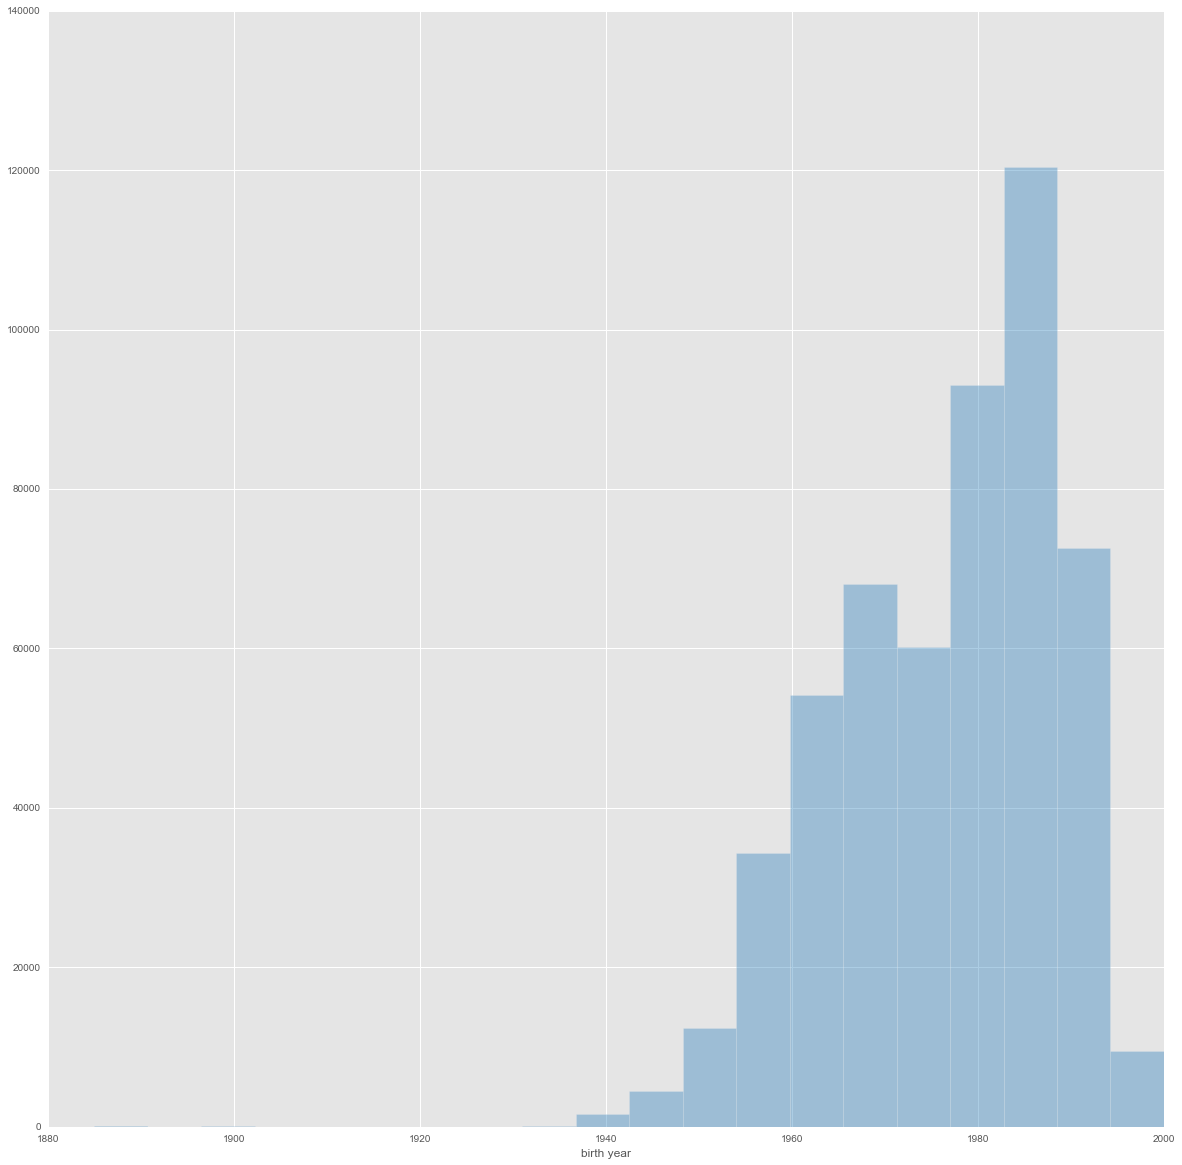

In [58]:
sns.distplot(df_subscribers['birth year'], kde=False, bins=20, color='#3182bd')

In [59]:
df_birthyear = df_subscribers['birth year']
df_birthyear = df_birthyear[df_birthyear>=1915]

In [60]:
df_birthyear.describe()

count    530797.000000
mean       1976.481120
std          11.708979
min        1917.000000
25%        1968.000000
50%        1979.000000
75%        1986.000000
max        2000.000000
Name: birth year, dtype: float64

### Gender

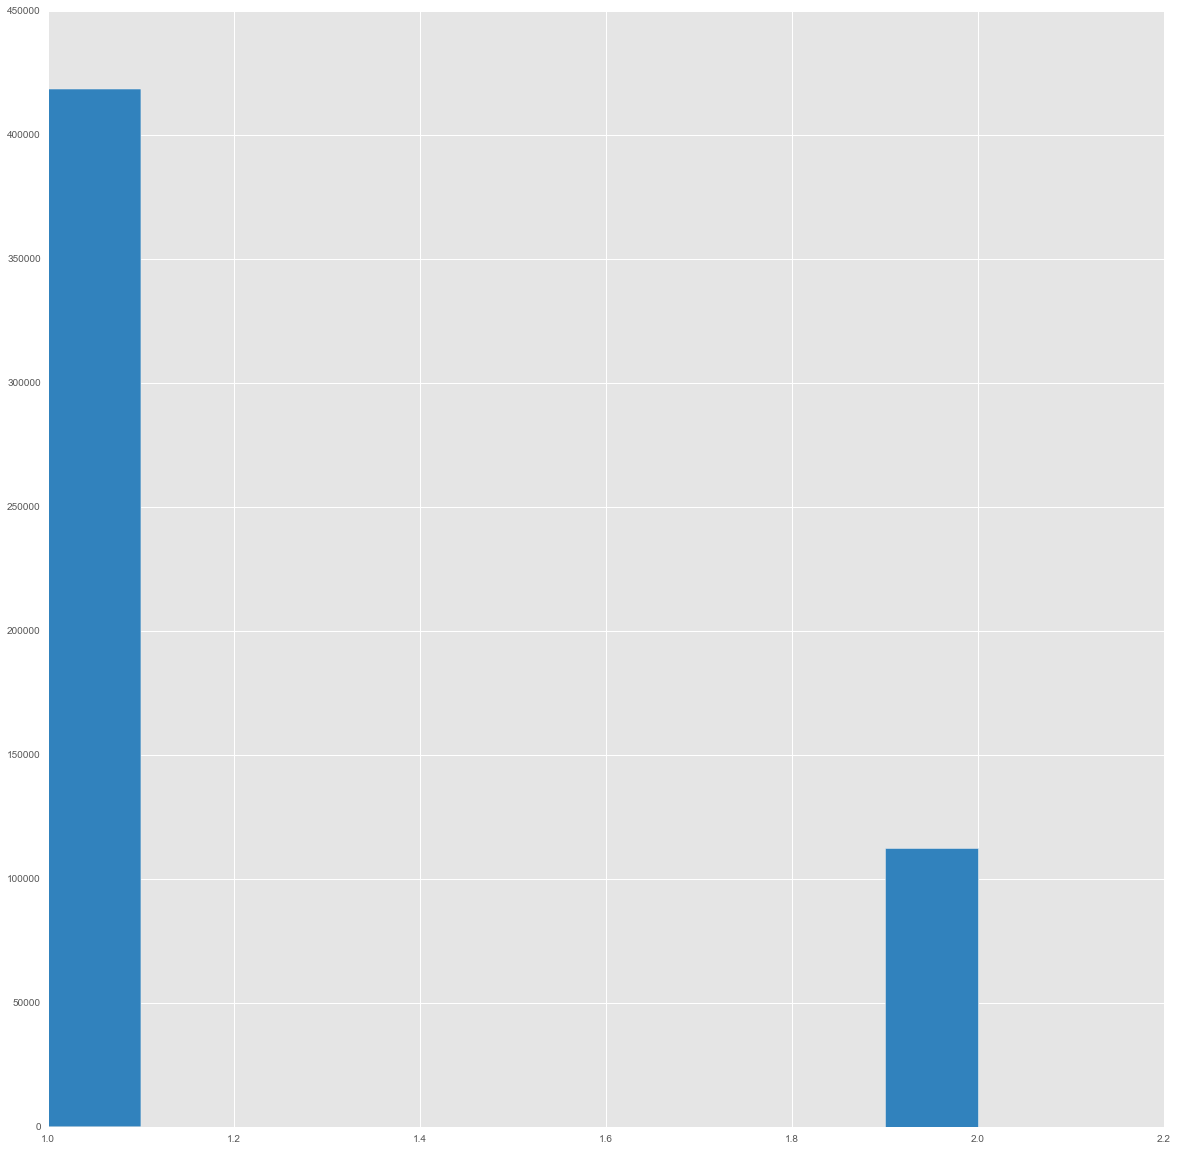

In [61]:
df_subscribers['gender'].hist(color='#3182bd')

In [62]:
(df_subscribers['gender']-1).describe()

count    531049.000000
mean          0.212009
std           0.408731
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: gender, dtype: float64

### Trip duration and birth year vs. gender

In [63]:
grp = df_subscribers.groupby('gender')['tripduration', 'birth year'].mean()

In [64]:
grp

,tripduration,birth year
gender,,
1,744.682509,1976.117698
2,894.767193,1977.649258


# Explore number of trip started at given station

In [16]:
# grp_tripsStartedAtID = df.groupby('start station id')[['tripduration']].count()
# grp_tripsStartedAtID = np.round(grp_tripsStartedAtID/grp_tripsStartedAtID.max()*250)
# grp_tripsStartedAtID[grp_tripsStartedAtID==0] = 1
# grp_tripsStartedAtID = grp_tripsStartedAtID.astype(int)

# Explore number of trips finished at given station

In [17]:
# grp_tripsEndedAtID = df.groupby('end station id')[['tripduration']].count()
# grp_tripsEndedAtID = np.round(grp_tripsEndedAtID/grp_tripsEndedAtID.max()*250)
# grp_tripsEndedAtID[grp_tripsEndedAtID==0] = 1
# grp_tripsEndedAtID = grp_tripsEndedAtID.astype(int)

In [18]:
# p1 = plotMap()
# p1 = plotStations(p1, grp_tripsStartedAtID, lut_StationNames)
# p2 = plotMap()
# p2 = plotStations(p2, grp_tripsEndedAtID, lut_StationNames)
# # p1 = plotMapStations(grp_tripsStartedAtID, lut_StationNames)
# # p2 = plotMapStations(grp_tripsEndedAtID, lut_StationNames)
# p2.x_range = p1.x_range
# p2.y_range = p1.y_range

In [19]:
# from bokeh.models.widgets import Panel, Tabs
# tab1 = Panel(child=p1, title="Started")
# tab2 = Panel(child=p2, title="Ended")
# tabs = Tabs(tabs=[ tab1, tab2 ])

# bk.show(tabs)

# Explore number of trips started at a given station vs. time

In [20]:
df_tripCount = df.loc[:, ['start station id', 'starttime']]
df_tripCount['started trips'] = 1
# df_tripCount.head()

df_tripCount = df_tripCount.groupby([pd.Grouper(freq='D', key='starttime'), 'start station id']).sum()
df_tripCount = df_tripCount.unstack(level=0)['started trips'].reset_index()
df_tripCount = pd.merge(lut_StationNames.reset_index(), df_tripCount.fillna(0))
df_tripCount['radius'] = df_tripCount.loc[:, pd.to_datetime(df_tripCount.columns[6])]
df_tripCount.columns = df_tripCount.columns.format()
# df_tripCount = df_tripCount.unstack().fillna(0).stack()

start_day = '20160201'
stop_day = '20160208'
source = ColumnDataSource(
    2*pd.concat([df_tripCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripCount.loc[:, 'radius']],
               axis=1)
)

lat = -40.7278736
lon = -73.9772813
axis_range = 5e3

plot = plotMap(lat, lon, axis_range)
plot.circle(x=df_tripCount['x'].values, 
            y=df_tripCount['y'].values, 
            radius='radius', 
            source=source,
            color='#3186cc',
            fill_color='#3186cc',
            alpha=.4)

def callback(source=source):
    data = source.get('data')
    f = cb_obj.get('value')
    date = sorted(data.keys())[f-1]
    print(date)
    r = data[date]
    data['radius'] = r
    source.trigger('change')

slider = Slider(start=1, end=len(sorted(source.data.keys())[:-4]), value=1, step=1, title="day",
                callback=CustomJS.from_py_func(callback), 
                orientation='horizontal')

layout = vform(plot, slider)

show(layout)
save(layout, 'test.html')


/Users/gdavid/anaconda/lib/python3.5/site-packages/bokeh/io.py:393: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warnings.warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/Users/gdavid/anaconda/lib/python3.5/site-packages/bokeh/io.py:398: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warnings.warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


In [21]:
# df_tripCount = df.loc[:, ['start station id', 'starttime']]
# df_tripCount['started trips'] = 1

# df_tripCount = df_tripCount.groupby([pd.Grouper(freq='H', key='starttime'), 'start station id']).sum()
# df_tripCount = df_tripCount.unstack(level=0)['started trips'].reset_index()
# df_tripCount = pd.merge(lut_StationNames.reset_index(), df_tripCount.fillna(0))
# df_tripCount['radius'] = df_tripCount.loc[:, pd.to_datetime(df_tripCount.columns[6])]
# df_tripCount.columns = df_tripCount.columns.format()

# # source = ColumnDataSource(df_tripCount.iloc[:, 6:])
# start_day = '20160201'
# stop_day = '20160202'
# source = ColumnDataSource(
#     10*pd.concat([df_tripCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
#                df_tripCount.loc[:, 'radius']],
#                axis=1)
# )

# lat = -40.7278736
# lon = -73.9772813
# axis_range = 2e3

# plot = plotMap(lat, lon, axis_range)
# plot.circle(x=df_tripCount['x'].values, 
#             y=df_tripCount['y'].values, 
#             radius='radius', 
#             source=source,
#             color='#3186cc',
#             fill_color='#3186cc',
#             alpha=.4)

# def callback(source=source):
#     data = source.get('data')
#     f = cb_obj.get('value')
#     date = sorted(data.keys())[f-1]
#     print(date)
#     r = data[date]
#     data['radius'] = r
#     source.trigger('change')

# slider = Slider(start=1, end=len(sorted(source.data.keys())[:-4]), value=1, step=1, title="day",
#                 callback=CustomJS.from_py_func(callback), 
#                 orientation='horizontal')

# layout = vform(plot, slider)

# show(layout)
# save(layout, 'test.html')



In [22]:
# df_tripStartedCount = df.loc[:, ['start station id', 'starttime']]
# df_tripStartedCount['started trips'] = 1

# df_tripStartedCount = df_tripStartedCount.groupby([pd.Grouper(freq='H', key='starttime'), 'start station id']).sum()
# df_tripStartedCount = df_tripStartedCount.unstack(level=0)['started trips'].reset_index()
# df_tripStartedCount = pd.merge(lut_StationNames.reset_index(), df_tripStartedCount.fillna(0))
# df_tripStartedCount['radius'] = df_tripStartedCount.loc[:, pd.to_datetime(df_tripStartedCount.columns[6])]
# df_tripStartedCount.columns = df_tripStartedCount.columns.format()

# # source = ColumnDataSource(df_tripStartedCount.iloc[:, 6:])
# start_day = '20160201'
# stop_day = '20160202'
# source = ColumnDataSource(
#     10*pd.concat([df_tripStartedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
#                df_tripStartedCount.loc[:, 'radius']],
#                axis=1)
# )

# lat = -40.7278736
# lon = -73.9772813
# axis_range = 2e3

# plot = plotMap(lat, lon, axis_range)
# plot.circle(x=df_tripStartedCount['x'].values, 
#             y=df_tripStartedCount['y'].values, 
#             radius='radius', 
#             source=source,
#             color='#3186cc',
#             fill_color='#3186cc',
#             alpha=.4)

# def callback(source=source):
#     data = source.get('data')
#     f = cb_obj.get('value')
#     date = sorted(data.keys())[f-1]
#     print(date)
#     r = data[date]
#     data['radius'] = r
#     source.trigger('change')

# slider = Slider(start=1, end=len(sorted(source.data.keys())[:-4]), value=1, step=1, title="day",
#                 callback=CustomJS.from_py_func(callback), 
#                 orientation='horizontal')

# layout = vform(plot, slider)

# show(layout)
# save(layout, 'test.html')



In [23]:
# df_tripEndedCount = df.loc[:, ['end station id', 'stoptime']]
# df_tripEndedCount['ended trips'] = 1

# df_tripEndedCount = df_tripEndedCount.groupby([pd.Grouper(freq='H', key='stoptime'), 'end station id']).sum()
# df_tripEndedCount = df_tripEndedCount.unstack(level=0)['ended trips'].reset_index()
# df_tripEndedCount = pd.merge(lut_StationNamesEnded.reset_index(), df_tripEndedCount.fillna(0))
# df_tripEndedCount['radius'] = df_tripEndedCount.loc[:, pd.to_datetime(df_tripEndedCount.columns[6])]
# df_tripEndedCount.columns = df_tripEndedCount.columns.format()

# # source = ColumnDataSource(df_tripEndedCount.iloc[:, 6:])
# start_day = '20160201'
# stop_day = '20160202'
# source = ColumnDataSource(
#     10*pd.concat([df_tripEndedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
#                df_tripEndedCount.loc[:, 'radius']],
#                axis=1)
# )

# lat = -40.7278736
# lon = -73.9772813
# axis_range = 2e3

# plot = plotMap(lat, lon, axis_range)
# plot.circle(x=df_tripCount['x'].values, 
#             y=df_tripCount['y'].values, 
#             radius='radius', 
#             source=source,
#             color='#3186cc',
#             fill_color='#3186cc',
#             alpha=.4)

# def callback(source=source):
#     data = source.get('data')
#     f = cb_obj.get('value')
#     date = sorted(data.keys())[f-1]
#     print(date)
#     r = data[date]
#     data['radius'] = r
#     source.trigger('change')

# slider = Slider(start=1, end=len(sorted(source.data.keys())[:-4]), value=1, step=1, title="day",
#                 callback=CustomJS.from_py_func(callback), 
#                 orientation='horizontal')

# layout = vform(plot, slider)

# show(layout)
# save(layout, 'test.html')


# Overview of hourly trips in 1 day

In [70]:
df_tripStartedCount = df.loc[:, ['start station id', 'starttime']]
df_tripStartedCount['started trips'] = 1

df_tripStartedCount = df_tripStartedCount.groupby([pd.Grouper(freq='H', key='starttime'), 'start station id']).sum()
df_tripStartedCount = df_tripStartedCount.unstack(level=0)['started trips'].reset_index()
df_tripStartedCount = pd.merge(lut_StationNames.reset_index(), df_tripStartedCount.fillna(0))
df_tripStartedCount['radius'] = df_tripStartedCount.loc[:, pd.to_datetime(df_tripStartedCount.columns[6])]
df_tripStartedCount.columns = df_tripStartedCount.columns.format()

radius_factor = 20

# source = ColumnDataSource(df_tripStartedCount.iloc[:, 6:])
start_day = '20160201'
stop_day = '20160202'
source1 = ColumnDataSource(
    radius_factor*pd.concat([df_tripStartedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripStartedCount.loc[:, 'radius']],
               axis=1)
)

lat = -40.7278736
lon = -73.9772813
lat = -40.7437815
lon = -73.9757094
axis_range = 5e3

plot1 = plotMap(lat, lon, axis_range)
plot1.circle(x=df_tripStartedCount['x'].values, 
            y=df_tripStartedCount['y'].values, 
            radius='radius', 
            source=source1,
            color='#3186cc',
            fill_color='#3186cc',
            alpha=.4)
plot1.title='Hourly volume of trips started in 1 day'

df_tripEndedCount = df.loc[:, ['end station id', 'stoptime']]
df_tripEndedCount['ended trips'] = 1

df_tripEndedCount = df_tripEndedCount.groupby([pd.Grouper(freq='H', key='stoptime'), 'end station id']).sum()
df_tripEndedCount = df_tripEndedCount.unstack(level=0)['ended trips'].reset_index()
df_tripEndedCount = pd.merge(lut_StationNamesEnded.reset_index(), df_tripEndedCount.fillna(0))
df_tripEndedCount['radius'] = df_tripEndedCount.loc[:, pd.to_datetime(df_tripEndedCount.columns[6])]
df_tripEndedCount.columns = df_tripEndedCount.columns.format()

source2 = ColumnDataSource(
    radius_factor*pd.concat([df_tripEndedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripEndedCount.loc[:, 'radius']],
               axis=1)
)

plot2 = plotMap(lat, lon, axis_range)
plot2.circle(x=df_tripEndedCount['x'].values, 
            y=df_tripEndedCount['y'].values, 
            radius='radius', 
            source=source2,
            color='#de2d26',
            fill_color='#de2d26',
            alpha=.4)
plot2.x_range = plot1.x_range
plot2.y_range = plot1.y_range
plot2.title='Hourly volume of trips ended in 1 day'

def callback(source1=source1, source2=source2):
    data1 = source1.get('data')
    f = cb_obj.get('value')
    date = sorted(data1.keys())[f-1]
#     print(date)
    r = data1[date]
    data1['radius'] = r
    source1.trigger('change')
    data2 = source2.get('data')
#     date = sorted(data.keys())[f-1]
#     print(date)
    r = data2[date]
    data2['radius'] = r
    source2.trigger('change')

slider = Slider(start=1, end=len(sorted(source1.data.keys())[:-4]), value=1, step=1, title="hour",
                callback=CustomJS.from_py_func(callback), 
                orientation='horizontal')

layout = hplot(plot1, plot2)
layout = vform(layout, slider)

show(layout)
save(layout, 'OverviewOfHourlyTripsInOneDay.html')


/Users/gdavid/anaconda/lib/python3.5/site-packages/bokeh/io.py:393: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warnings.warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/Users/gdavid/anaconda/lib/python3.5/site-packages/bokeh/io.py:398: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warnings.warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")


# Overview of daily trips in 1 week

In [68]:
df_tripStartedCount = df.loc[:, ['start station id', 'starttime']]
df_tripStartedCount['started trips'] = 1

df_tripStartedCount = df_tripStartedCount.groupby([pd.Grouper(freq='D', key='starttime'), 'start station id']).sum()
df_tripStartedCount = df_tripStartedCount.unstack(level=0)['started trips'].reset_index()
df_tripStartedCount = pd.merge(lut_StationNames.reset_index(), df_tripStartedCount.fillna(0))
df_tripStartedCount['radius'] = df_tripStartedCount.loc[:, pd.to_datetime(df_tripStartedCount.columns[6])]
df_tripStartedCount.columns = df_tripStartedCount.columns.format()

radius_factor = 3

# source = ColumnDataSource(df_tripStartedCount.iloc[:, 6:])
start_day = '20160201'
stop_day = '20160207'
source1 = ColumnDataSource(
    radius_factor*pd.concat([df_tripStartedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripStartedCount.loc[:, 'radius']],
               axis=1)
)

lat = -40.7278736
lon = -73.9772813
lat = -40.7437815
lon = -73.9757094
axis_range = 5e3

plot1 = plotMap(lat, lon, axis_range)
plot1.circle(x=df_tripStartedCount['x'].values, 
            y=df_tripStartedCount['y'].values, 
            radius='radius', 
            source=source1,
            color='#3186cc',
            fill_color='#3186cc',
            alpha=.4)
plot1.title='Daily volume of trips started in 1 week'

df_tripEndedCount = df.loc[:, ['end station id', 'stoptime']]
df_tripEndedCount['ended trips'] = 1

df_tripEndedCount = df_tripEndedCount.groupby([pd.Grouper(freq='D', key='stoptime'), 'end station id']).sum()
df_tripEndedCount = df_tripEndedCount.unstack(level=0)['ended trips'].reset_index()
df_tripEndedCount = pd.merge(lut_StationNamesEnded.reset_index(), df_tripEndedCount.fillna(0))
df_tripEndedCount['radius'] = df_tripEndedCount.loc[:, pd.to_datetime(df_tripEndedCount.columns[6])]
df_tripEndedCount.columns = df_tripEndedCount.columns.format()

source2 = ColumnDataSource(
    radius_factor*pd.concat([df_tripEndedCount.loc[:, pd.to_datetime(start_day).strftime('%Y-%m-%d %H:%M:%S'):pd.to_datetime(stop_day).strftime('%Y-%m-%d %H:%M:%S')],
               df_tripEndedCount.loc[:, 'radius']],
               axis=1)
)

plot2 = plotMap(lat, lon, axis_range)
plot2.circle(x=df_tripEndedCount['x'].values, 
            y=df_tripEndedCount['y'].values, 
            radius='radius', 
            source=source2,
            color='#de2d26',
            fill_color='#de2d26',
            alpha=.4)
plot2.x_range = plot1.x_range
plot2.y_range = plot1.y_range
plot2.title='Daily volume of trips ended in 1 week'

def callback(source1=source1, source2=source2):
    data1 = source1.get('data')
    f = cb_obj.get('value')
    date = sorted(data1.keys())[f-1]
#     print(date)
    r = data1[date]
    data1['radius'] = r
    source1.trigger('change')
    data2 = source2.get('data')
#     date = sorted(data.keys())[f-1]
#     print(date)
    r = data2[date]
    data2['radius'] = r
    source2.trigger('change')

slider = Slider(start=1, end=len(sorted(source1.data.keys())[:-4]), value=1, step=1, title="day",
                callback=CustomJS.from_py_func(callback), 
                orientation='horizontal')

layout = hplot(plot1, plot2)
layout = vform(layout, slider)

show(layout)
save(layout, 'OverviewOfDailyTripsInOneWeek.html')

/Users/gdavid/anaconda/lib/python3.5/site-packages/bokeh/io.py:393: UserWarning: save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN
  warnings.warn("save() called but no resources were supplied and output_file(...) was never called, defaulting to resources.CDN")
/Users/gdavid/anaconda/lib/python3.5/site-packages/bokeh/io.py:398: UserWarning: save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'
  warnings.warn("save() called but no title was supplied and output_file(...) was never called, using default title 'Bokeh Plot'")
